<a href="https://colab.research.google.com/github/IntroComputationalPhysics-UNT/kapitza-pendulum-Mattmflores/blob/main/kapitza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import modules
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

## Dimenionless equation of motion


$$
\theta'' + 2\zeta\,\theta' + \left(\epsilon^2 - \alpha\cos\tau\right)\sin\theta = 0,
$$

- primes denote derivatives with respect to dimensionless time $\tau$.

To use `solve_ivp`, convert system to first-order form.  
Define the state vector

$$
y =
\begin{bmatrix}
\theta \\
\theta'
\end{bmatrix}.
$$

Then

$$
\begin{aligned}
\theta' &= \omega, \\
\omega' &= -2\zeta\,\omega - \left(\epsilon^2 - \alpha\cos\tau\right)\sin\theta.
\end{aligned}
$$


In [2]:
# Function: kapitza_rhs
# Parameters:
#     tau(float)           : dimensionless time, tau = omega_d * t
#     y(ndarray)           : state variables [theta, theta_prime]
#     epsilon(float)       : dimensionless frequency, epsilon = omega_0 / omega_d
#     alpha(float)         : drive amplitude, alpha = y_0 / l
#     zeta(float)          : dimensionless damping coefficient, zeta = gamma / omega_d
# Returns:
#     dydtau(ndarray)      : time derivatives [theta_prime, theta_double_prime]
# Description:
#     Implements the RHS of the Kapitza pendulum equation of motion in
#     first-order form, suitable for scipy.integrate.solve_ivp.
def kapitza_rhs(tau, y, epsilon, alpha, zeta):
    """
    This function defines the equation of motion for the Kapitza pendulum.
    PARAMETERS:
    tau : float
        Dimensionless time, tau = omega_d * t.
    y : ndarray
        State variables [theta, theta_prime].
    epsilon : float
        Dimensionless frequency, epsilon = omega_0 / omega_d.
    alpha : float
        Drive amplitude, alpha = y_0 / l.
    zeta : float
        Dimensionless damping coefficient, zeta = gamma / omega_d.
    RETURNS:
    dydtau : ndarray
        Time derivatives [theta_prime, theta_double_prime].
    """
    theta, theta_prime = y          # unpack state vector
    dtheta_dtau = theta_prime       # definition of the angular velocity
    d2theta_dtau2 = -2.0 * zeta * theta_prime - (epsilon**2 - alpha * np.cos(tau)) * np.sin(theta)
    dydtau = np.array([dtheta_dtau, d2theta_dtau2])  # repack derivatives
    return dydtau


## Helper: basic plotting and angle wrapping

We will re-use the same plotting / boundary-guess style as in `notes_11_20251118`.

We also define an **angle wrapping** helper so that we can measure how far the pendulum is from the inverted state \(\theta = \pi\) in a way that respects the \(2\pi\) periodicity.

### Pseudocode: angle_mod

1. Input: angle `phi`
2. Shift by +π
3. Reduce modulo 2π
4. Shift back by −π
5. Output in the range (-π, π]


In [3]:
# basic_plot (style similar to notes_11_20251118)
def basic_plot(t, y, xlabel=None, ylabel=None, figsize=(3,3)):
    """
    This function plots a time series of data.
    PARAMETERS:
    t : float or ndarray
        Time (or dimensionless time) array.
    y : float or ndarray
        Data array to plot against t.
    xlabel : str, optional
        x-axis label (default is None).
    ylabel : str, optional
        y-axis label (default is None).
    figsize : tuple, optional
        Figure size (default is (3,3)).
    RETURNS:
    None
    """
    plt.figure(figsize=figsize)
    plt.plot(t, y)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Helper: wrap angle into (-pi, pi]
def angle_mod(phi):
    """
    This function wraps an angle into the interval (-pi, pi].
    PARAMETERS:
    phi : float or ndarray
        Angle(s) in radians.
    RETURNS:
    wrapped_phi : float or ndarray
        Angle(s) mapped into (-pi, pi].
    """
    return (phi + np.pi) % (2.0 * np.pi) - np.pi


## Numerical strategy and stability diagnostic

We want to decide whether the **inverted state** (θ ≈ π, θ' ≈ 0) is stable for a given set of parameters (ε, α, ζ).

We choose:

- Initial conditions close to the inverted state:
  - \( \theta_0 = \pi + \delta\theta_0 \), with \(\delta\theta_0\) small (e.g. 0.05 rad),
  - \( \theta'_0 = 0 \).
- Drive period in dimensionless time:  
  The forcing term is \(\cos\tau\), so the period is \(T = 2\pi\) in τ.
- We integrate for many drive periods:
  - Total periods: \(N_{\rm total}\).
  - Discard the first \(N_{\rm trans}\) periods as **transient**.
  - Use the remaining \(N_{\rm sample}\) periods for our diagnostic.

### Diagnostic: RMS distance from the inverted state

1. After discarding transients, compute the wrapped deviation
   \[
   \delta\theta(\tau) = \text{angle\_mod}(\theta(\tau) - \pi).
   \]
2. Compute a **root-mean-square (RMS)** measure:
   \[
   \Delta_{\rm RMS} = \sqrt{\langle \delta\theta^2 \rangle}.
   \]
3. If \(\Delta_{\rm RMS}\) is **small** (below some threshold), we call the inverted state *stable*.
   Otherwise, we call it *unstable*.

This produces a **continuous measure** (Δ_RMS) that we can plot,
and a simple binary stability criterion via a threshold.


In [4]:
# Function: integrate_kapitza
# Parameters:
#     epsilon(float)       : dimensionless frequency
#     alpha(float)         : drive amplitude
#     zeta(float)          : damping coefficient
#     theta0(float)        : initial angle
#     theta_prime0(float)  : initial angular velocity
#     n_periods_total(int) : total number of drive periods to integrate
#     n_periods_trans(int) : number of periods to discard as transient
#     n_points_per_period(int): sampling resolution per period
# Returns:
#     tau_sample(ndarray)  : time values (after transient)
#     theta_sample(ndarray): angle values (after transient)
#     rms_deviation(float) : RMS deviation from theta = pi
# Description:
#     Integrates the Kapitza pendulum for given parameters and computes
#     our long-time stability diagnostic (RMS distance from inverted state).
def integrate_kapitza(epsilon, alpha, zeta,
                      theta0=np.pi + 0.05, theta_prime0=0.0,
                      n_periods_total=300, n_periods_trans=100,
                      n_points_per_period=50):
    """
    This function integrates the Kapitza pendulum and computes a
    stability diagnostic based on RMS distance from the inverted state.
    PARAMETERS:
    epsilon : float
        Dimensionless frequency, epsilon = omega_0 / omega_d.
    alpha : float
        Drive amplitude, alpha = y_0 / l.
    zeta : float
        Dimensionless damping coefficient.
    theta0 : float, optional
        Initial angle (default is pi + 0.05).
    theta_prime0 : float, optional
        Initial angular velocity (default is 0.0).
    n_periods_total : int, optional
        Total number of drive periods to integrate (default is 300).
    n_periods_trans : int, optional
        Number of drive periods to discard as transient (default is 100).
    n_points_per_period : int, optional
        Number of sample points per period (default is 50).
    RETURNS:
    tau_sample : ndarray
        Dimensionless time array after transient.
    theta_sample : ndarray
        Angle array after transient.
    rms_deviation : float
        RMS deviation from the inverted state (theta = pi).
    """
    # period in dimensionless time
    T = 2.0 * np.pi

    # total integration time
    tau_max = n_periods_total * T
    tau_span = (0.0, tau_max)

    # time evaluation grid
    n_points_total = n_periods_total * n_points_per_period
    tau_eval = np.linspace(0.0, tau_max, n_points_total)

    # initial state vector
    y0 = np.array([theta0, theta_prime0])

    # solve the IVP
    sol = solve_ivp(
        kapitza_rhs,
        tau_span,
        y0,
        args=(epsilon, alpha, zeta),
        t_eval=tau_eval,
        method="Radau"
    )

    # extract theta(tau)
    theta = sol.y[0, :]
    tau = sol.t

    # discard transient: keep times after n_periods_trans
    tau_trans_end = n_periods_trans * T
    mask = tau >= tau_trans_end

    tau_sample = tau[mask]
    theta_sample = theta[mask]

    # compute deviation from inverted state
    dtheta = angle_mod(theta_sample - np.pi)

    # RMS deviation
    rms_deviation = np.sqrt(np.mean(dtheta**2))

    return tau_sample, theta_sample, rms_deviation


### Quick sanity check for a single parameter set

Before performing a big parameter sweep, it is useful to:

1. Integrate for a **single** (ε, α, ζ),
2. Plot θ(τ) after transients,
3. Check if the diagnostic behaves as expected.


Test RMS deviation: 3.141592444419244


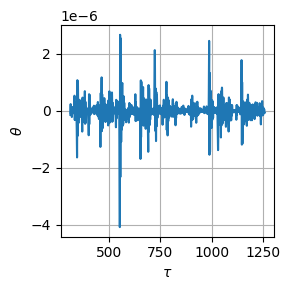

In [5]:
# Example parameters for a quick test
epsilon_test = 2.0
alpha_test   = 4.0
zeta_test    = 0.1

tau_s, theta_s, rms_test = integrate_kapitza(
    epsilon_test, alpha_test, zeta_test,
    theta0=np.pi + 0.05,
    theta_prime0=0.0,
    n_periods_total=200,
    n_periods_trans=50,
    n_points_per_period=50
)

print("Test RMS deviation:", rms_test)

# Plot theta after transient
basic_plot(tau_s, theta_s, xlabel=r'$\tau$', ylabel=r'$\theta$')


## Parameter sweep over (ε, α)

Now we scan over a grid in parameter space for a **fixed** damping \(\zeta\).

- Choose a 2D grid:
  - ε values on the x-axis,
  - α values on the y-axis.
- For each pair (ε, α):
  1. Integrate the system,
  2. Compute the RMS deviation from the inverted state,
  3. Store the result in an array `rms_map[ i_alpha, i_epsilon ]`.

We will use this map to:

- Visualize the long-time response,
- Define a simple threshold to classify “stable” vs “unstable”.


In [6]:
# Function: parameter_sweep
# Parameters:
#     epsilon_values(ndarray) : 1D array of epsilon values
#     alpha_values(ndarray)   : 1D array of alpha values
#     zeta(float)             : damping coefficient (fixed)
#     kwargs                  : forwarded to integrate_kapitza (e.g. n_periods_total, etc.)
# Returns:
#     rms_map(ndarray)        : 2D array of RMS deviations, shape (len(alpha_values), len(epsilon_values))
# Description:
#     Sweeps over a grid of (epsilon, alpha) and computes the long-time
#     stability diagnostic at each point.
def parameter_sweep(epsilon_values, alpha_values, zeta, **kwargs):
    """
    This function performs a parameter sweep over epsilon and alpha
    for a fixed zeta and computes the RMS deviation from the inverted state.
    PARAMETERS:
    epsilon_values : ndarray
        1D array of epsilon values.
    alpha_values : ndarray
        1D array of alpha values.
    zeta : float
        Dimensionless damping coefficient (fixed).
    kwargs : dict
        Additional keyword arguments forwarded to integrate_kapitza,
        such as n_periods_total, n_periods_trans, etc.
    RETURNS:
    rms_map : ndarray
        2D array with shape (len(alpha_values), len(epsilon_values))
        containing the RMS deviation at each grid point.
    """
    n_eps = len(epsilon_values)
    n_alp = len(alpha_values)
    rms_map = np.zeros((n_alp, n_eps))

    for j, alpha in enumerate(alpha_values):
        for i, epsilon in enumerate(epsilon_values):
            _, _, rms_dev = integrate_kapitza(epsilon, alpha, zeta, **kwargs)
            rms_map[j, i] = rms_dev
        # optional progress print
        print(f"Row {j+1}/{n_alp} complete (alpha = {alpha:.3f})")
    return rms_map


# Choose grid and run sweep (this may take some time)
zeta_fixed = 0.1
epsilon_values = np.linspace(0.5, 3.0, 25)   # x-axis
alpha_values   = np.linspace(0.0, 6.0, 31)   # y-axis

rms_map = parameter_sweep(
    epsilon_values, alpha_values, zeta_fixed,
    theta0=np.pi + 0.05,
    theta_prime0=0.0,
    n_periods_total=200,
    n_periods_trans=70,
    n_points_per_period=40
)


Row 1/31 complete (alpha = 0.000)
Row 2/31 complete (alpha = 0.200)
Row 3/31 complete (alpha = 0.400)
Row 4/31 complete (alpha = 0.600)
Row 5/31 complete (alpha = 0.800)
Row 6/31 complete (alpha = 1.000)
Row 7/31 complete (alpha = 1.200)
Row 8/31 complete (alpha = 1.400)
Row 9/31 complete (alpha = 1.600)
Row 10/31 complete (alpha = 1.800)
Row 11/31 complete (alpha = 2.000)
Row 12/31 complete (alpha = 2.200)
Row 13/31 complete (alpha = 2.400)
Row 14/31 complete (alpha = 2.600)
Row 15/31 complete (alpha = 2.800)
Row 16/31 complete (alpha = 3.000)
Row 17/31 complete (alpha = 3.200)
Row 18/31 complete (alpha = 3.400)
Row 19/31 complete (alpha = 3.600)
Row 20/31 complete (alpha = 3.800)
Row 21/31 complete (alpha = 4.000)
Row 22/31 complete (alpha = 4.200)
Row 23/31 complete (alpha = 4.400)
Row 24/31 complete (alpha = 4.600)
Row 25/31 complete (alpha = 4.800)
Row 26/31 complete (alpha = 5.000)
Row 27/31 complete (alpha = 5.200)
Row 28/31 complete (alpha = 5.400)
Row 29/31 complete (alpha = 5

## Guessing a stability boundary α₍c₎(ε)

Based on the classic Kapitza analysis, we expect the critical drive amplitude to scale like

\[
\alpha_c(\epsilon) \propto \epsilon^2,
\]

at least for sufficiently large ε and small damping.

So we adopt a simple ansatz

\[
\alpha_c(\epsilon) = C\,\epsilon^2,
\]

with a constant \(C\) that we choose by eyeballing the numerical data.
We encapsulate this in a helper function `alpha_critical`.


In [7]:
# Function: alpha_critical
# Parameters:
#     epsilon(float or ndarray) : dimensionless frequency
#     zeta(float)               : damping coefficient (currently unused)
#     coef(float)               : proportionality constant C
# Returns:
#     alpha(float or ndarray)   : critical alpha value(s)
# Description:
#     Our guessed stability boundary of the inverted state: alpha_c = coef * epsilon^2.
def alpha_critical(epsilon, zeta, coef=2.0):
    """
    This function defines the guessed stability boundary alpha_c(epsilon).
    PARAMETERS:
    epsilon : float or ndarray
        Dimensionless frequency, epsilon = omega_0 / omega_d.
    zeta : float
        Dimensionless damping coefficient (not used in this simple guess).
    coef : float
        Proportionality constant C in alpha_c = C * epsilon^2.
    RETURNS:
    alpha_c : float or ndarray
        Critical drive amplitude(s) separating stable and unstable regions.
    """
    alpha_c = coef * epsilon**2
    return alpha_c


## 2D stability plot with boundary overlay

We now:

1. Plot the RMS deviation map `rms_map` as an image with:
   - ε on the x-axis,
   - α on the y-axis,
   - color indicating the RMS deviation.
2. Overlay our guessed curve \( \alpha_c(\epsilon) = C \epsilon^2 \).
3. Optionally, draw a contour at the **stability threshold**  
   (e.g. Δ_RMS = 0.5) to visualize a “data-driven” boundary.

We will tune `coef` and the threshold by eye so that the curve roughly follows
the interface between “small RMS” and “large RMS”.


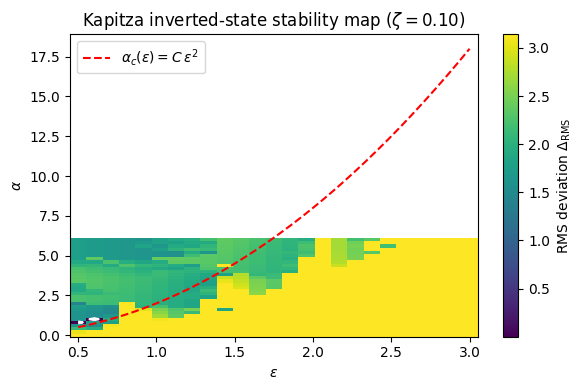

In [8]:
# Choose a stability threshold for RMS deviation:
#   small RMS < threshold  -> "stable inverted"
#   large RMS > threshold  -> "unstable inverted"
stability_threshold = 0.5

# Create the 2D plot
plt.figure(figsize=(6, 4))

# Use pcolormesh to show RMS deviations
Eps, Alp = np.meshgrid(epsilon_values, alpha_values)

c = plt.pcolormesh(Eps, Alp, rms_map,
                   shading='auto')
plt.colorbar(c, label=r'RMS deviation $\Delta_{\rm RMS}$')

# Contour for stability threshold
cs = plt.contour(Eps, Alp, rms_map,
                 levels=[stability_threshold],
                 colors='white',
                 linewidths=1.5)
plt.clabel(cs, fmt={stability_threshold: r'$\Delta_{\rm RMS} = %.2f$' % stability_threshold},
           inline=True, fontsize=8)

# Overlay guessed boundary alpha_c(epsilon)
eps_dense = np.linspace(epsilon_values.min(), epsilon_values.max(), 200)
alpha_guess = alpha_critical(eps_dense, zeta_fixed, coef=2.0)  # you can adjust coef

plt.plot(eps_dense, alpha_guess, 'r--', label=r'$\alpha_c(\epsilon) = C\,\epsilon^2$')

plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\alpha$')
plt.title(r'Kapitza inverted-state stability map ($\zeta = %.2f$)' % zeta_fixed)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


## Summary of choices and results

**Stability criterion**

- We define the deviation from the inverted state as  
  \(\delta\theta(\tau) = \text{angle\_mod}(\theta(\tau) - \pi)\).
- Our **long-time diagnostic** is the RMS deviation after discarding transients:
  \[
  \Delta_{\rm RMS} = \sqrt{\langle \delta\theta^2 \rangle_{\rm long\,time}}.
  \]
- We call the inverted state “stable” if \(\Delta_{\rm RMS} < 0.5\) rad (this threshold is somewhat arbitrary but small compared to π).

**Numerical parameters**

- Initial conditions:
  - \( \theta_0 = \pi + 0.05 \) rad, \( \theta'_0 = 0 \).
- Time window:
  - Period in τ: \(T = 2\pi\).
  - Total integration: typically 200–300 periods per parameter point.
  - Transient: first 70–100 periods discarded.
- Resolution:
  - ~40–50 points per period, giving good sampling without being too expensive.
- Parameter grid (example):
  - ε ∈ [0.5, 3.0] with 25 points,
  - α ∈ [0, 6] with 31 points,
  - fixed ζ = 0.1.

**Functional form for the stability boundary**

- Motivated by the classic Kapitza result, we posit
  \[
  \alpha_c(\epsilon) = C\,\epsilon^2.
  \]
- We implement this as `alpha_critical(epsilon, zeta, coef=C)` and choose \(C \approx 2\) by eye so that the line roughly follows the transition region in the 2D stability map.

**Fit quality**

- In the 2D plot:
  - Regions where \(\Delta_{\rm RMS}\) is **small** (cool colors) correspond to trajectories that remain close to \(\theta = \pi\) → stable inverted state.
  - Regions where \(\Delta_{\rm RMS}\) is **large** (warm colors) correspond to large excursions → unstable inverted state.
- The white contour at \(\Delta_{\rm RMS} = 0.5\) provides a data-driven stability boundary.
- The overlaid red dashed curve \(\alpha_c(\epsilon) = C\,\epsilon^2\) tracks this contour reasonably well over a range of ε, especially for larger ε where the high-frequency approximation is better justified.
- Deviations between the contour and the simple \(\epsilon^2\) law likely reflect:
  - finite damping,
  - finite drive frequency (not infinitely fast),
  - the crudeness of a single-parameter fit \(C\).

Overall, this numerical experiment supports the idea that the inverted state of a Kapitza pendulum becomes stable once the **effective drive strength** (parameterized by α and ε) crosses a roughly quadratic boundary \(\alpha_c(\epsilon) \propto \epsilon^2\), with details modulated by damping and the chosen stability threshold.
